<a href="https://colab.research.google.com/github/TomerDwek/Neural-Networks/blob/main/NN_EX3_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import time
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, t_train), (x_test, t_test) = mnist.load_data()

x_train, x_val, t_train, t_val = train_test_split(x_train, t_train, test_size=0.20, random_state=2)

x_train, x_val, x_test_images = tf.cast(x_train / 255.0, tf.float32), tf.cast(x_val / 255.0, tf.float32), tf.cast(x_test / 255.0, tf.float32) # normalize
t_test, t_train, t_val = tf.one_hot(t_test, 10),  tf.one_hot(t_train, 10), tf.one_hot(t_val, 10)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, t_train)).shuffle(10000).batch(50)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, t_val)).shuffle(10000).batch(50)
test_ds = tf.data.Dataset.from_tensor_slices((x_test_images, t_test)).batch(50)

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
def loss (y, t):
  return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=t, logits=y))

In [ ]:
def train(model, inputs, outputs, l_rate, training=False, keep_proba=None):
  opt = tf.keras.optimizers.Adam(learning_rate=l_rate)
  with tf.GradientTape() as t:
    current_loss = loss(model(inputs, training, keep_proba), outputs)
  
  grads = t.gradient(current_loss, model.variables)
  opt.apply_gradients(zip(grads, model.variables))

In [ ]:
# part 1 setting weights and biases
def weight_variable(shape, name):
    initial = tf.random.truncated_normal(shape, stddev=0.1)  
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)  # small positive values to prevent dying relus.
    return tf.Variable(initial,  name=name)

def conv2d(x, w, stride=1):
    return tf.nn.conv2d(x, w, strides=[1, stride, stride, 1], padding='SAME')
# zero padding to produce same size layer, stride=1.


def max_pooling_2x2(x):
    return tf.nn.max_pool2d(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
# max pooling layer, maximize 2x2 window, stride=2

In [ ]:
def predict(model, x, t, training=False, keep_prob=None):
  y = model(x, training, keep_prob)
  y = tf.argmax(y, 1)
  t = tf.argmax(t, 1)
  return y, t

In [ ]:
def recall(y, t, labels):
  return tf.reduce_mean(metrics.recall_score(t, y, labels, average=None, zero_division=0)).numpy()
  
def precision(y, t, labels):
  return tf.reduce_mean(metrics.precision_score(t, y, labels, average=None, zero_division=0)).numpy()

def F1_score(y, t, labels):
  return tf.reduce_mean(metrics.f1_score(t, y, labels, average=None, zero_division=0)).numpy()

def accuracy(y, t):
  # Train and evaluate
  correct_prediciton = tf.equal(tf.argmax(y, 1), tf.argmax(t, 1))
  return tf.reduce_mean(tf.cast(correct_prediciton, tf.float32))


In [ ]:
lbl = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
def calculate_train_stats(model, ds, training=False, keep_prob=None, timer=False):
  timer = time.time()
  train_recalls = []
  train_precisions = []
  train_F1_scores = []
  train_accuracies = []
  iter = 0

  i = 0
  while i < 13000:
    for images, labels in ds:
      train(model, images, labels, 0.001, training, keep_prob)
      if time and accuracy(model(images, training=False), labels) >= 0.99 and iter == 0:
        iter = i
        iter_time = (iter ,time.time() - timer)
      if i % 100 == 0:
        y, t = predict(model, images, labels)
        train_recalls.append(recall(y, t, lbl))
        train_precisions.append(precision(y, t, lbl))
        train_F1_scores.append(F1_score(y, t, lbl))
        train_accuracies.append(accuracy(model(images, training=False), labels))
        print("Step %d, training accuracy %g" % (i, accuracy(model(images, training=False), labels)))
      i += 1
      if i > 13000:
        break

  train_recall = tf.reduce_mean(train_recalls).numpy()
  train_precision = tf.reduce_mean(train_precisions).numpy()
  train_F1_score = tf.reduce_mean(train_F1_scores).numpy()
  train_accuracy = tf.reduce_mean(train_accuracies).numpy()
  if iter == 0:
    iter_time = (None, None)
  return train_recall, train_precision, train_F1_score, train_accuracy, iter_time

In [ ]:
def calculate_test_stats(model, ds):
  test_recalls = []
  test_precisions = []
  test_F1_scores = []
  test_accuracies = []

  for images, labels in ds:
    y, t = predict(model, images, labels)
    test_recalls.append(recall(y, t, lbl))
    test_precisions.append(precision(y, t, lbl))
    test_F1_scores.append(F1_score(y, t, lbl))
    test_accuracies.append(accuracy(model(images, training=False), labels))

  # Test Results
  test_recall = tf.reduce_mean(test_recalls).numpy()
  test_precision = tf.reduce_mean(test_precisions).numpy()
  test_F1_score = tf.reduce_mean(test_F1_scores).numpy()
  test_accuracy = tf.reduce_mean(test_accuracies).numpy()
  
  return test_recall, test_precision, test_F1_score, test_accuracy

In [ ]:
def calculate_num_of_weights(variables):
  sum = 0
  for var in variables:
    sum += tf.size(var).numpy()
  return sum

In [ ]:
def visualize(model, image, layerNum, chanelNum, activ=False):
  image = tf.reshape(image, [1, 28, 28, 1])

  layer = model.w_conv1
  bias = model.b_conv1
  if layerNum == 1:
    if activ:
      return tf.nn.relu(conv2d(image, layer) + bias)[0, :, :, chanelNum]
    return conv2d(image, layer)[0, :, :, chanelNum]

  if layerNum > 1:
    image = tf.nn.relu(conv2d(image, layer) + bias)
    layer = model.w_conv2
    bias = model.b_conv2
    if layerNum == 2:
      if activ:
        return tf.nn.relu(conv2d(image, layer) + bias)[0, :, :, chanelNum]
      return conv2d(image, layer)[0, :, :, chanelNum]

  if layerNum == 3:
    image = tf.nn.relu(conv2d(image, layer) + bias)
    layer = model.w_conv3
    bias = model.b_conv3
    if activ:
      return tf.nn.relu(conv2d(image, layer) + bias)[0, :, :, chanelNum]
    return conv2d(image, layer)[0, :, :, chanelNum]
  return None

In [ ]:
def show_visualizations(model, n_rows, n_cols, n_images, ds):
  plt.figure()
  f, axarr = plt.subplots(nrows=n_rows,ncols=n_cols, figsize=(8,8)) 
  if n_rows * n_cols > n_images:
    f.delaxes(axarr[n_rows-1][n_cols-1])
  for i in range(n_rows):
    for j in range(n_cols):
      p = visualize(model6, x_test_images[i * axarr.shape[1] + j + np.random.randint(low=0,high=ds.shape[0])], ((i + j) % 3 + 1), 25)
      axarr[i,j].imshow(p)
  plt.show()

In [ ]:
def show_convolutions(model, n_rows, n_cols, ds):
  plt.figure()
  f, axarr = plt.subplots(nrows=2,ncols=2, figsize=(8,8)) 
  img_num = np.random.randint(low=0,high=ds.shape[0])
  for i in range(n_rows):
    for j in range(n_cols):
      if j == 0:
        p = visualize(model3, x_train[img_num], i+1, 25)
      else:
        p = visualize(model3, x_train[img_num], i+1, 25, True)
      axarr[i,j].imshow(p)
  plt.show()

## Model 1
Logistic regression network without hidden layers

In [ ]:
class Model1:
  def __init__(self):
    self.w1 = tf.Variable(tf.zeros([784, 10]), name="Weights1") # 28*28=784
    self.b1 = tf.Variable(tf.zeros([10]) + 0.1, name="Biases1") # 0.1 for dying relus
    self.variables = [self.w1, self.b1]

  def __call__(self, x, training=False, keep_prob=None):
    x = tf.reshape(x , [-1, 28 * 28])
    return tf.nn.relu(tf.matmul(x, self.w1) + self.b1)

In [ ]:
start = time.time()
model1 = Model1()

# Calculate Recall, Precision, F1_Score, Accuracy of Traning data
train_recall1, train_precision1, train_f1_score1, train_accuracy1, iter_time1 = calculate_train_stats(model1, train_ds)
end = time.time()
time1 = end - start

# Calculate Recall, Precision, F1_Score, Accuracy of Validation data
val_recall1, val_precision1, val_f1_score1, val_accuracy1 = calculate_test_stats(model1, val_ds)

# Calculate Recall, Precision, F1_Score, Accuracy of Test data
test_recall1, test_precision1, test_f1_score1, test_accuracy1 = calculate_test_stats(model1, test_ds)

Step 0, training accuracy 0.62
Step 100, training accuracy 0.86
Step 200, training accuracy 0.86
Step 300, training accuracy 0.9
Step 400, training accuracy 0.86
Step 500, training accuracy 0.82
Step 600, training accuracy 0.84
Step 700, training accuracy 0.94
Step 800, training accuracy 0.82
Step 900, training accuracy 0.94
Step 1000, training accuracy 0.84
Step 1100, training accuracy 0.88
Step 1200, training accuracy 0.88
Step 1300, training accuracy 0.92
Step 1400, training accuracy 0.9
Step 1500, training accuracy 0.9
Step 1600, training accuracy 0.92
Step 1700, training accuracy 0.96
Step 1800, training accuracy 0.82
Step 1900, training accuracy 0.9
Step 2000, training accuracy 0.82
Step 2100, training accuracy 0.78
Step 2200, training accuracy 0.84
Step 2300, training accuracy 0.96
Step 2400, training accuracy 0.8
Step 2500, training accuracy 0.88
Step 2600, training accuracy 0.88
Step 2700, training accuracy 0.9
Step 2800, training accuracy 0.88
Step 2900, training accuracy 0.9

In [ ]:
print("Time = ", time1)
print("Weights amount = ", calculate_num_of_weights(model1.variables))
print("Training Results:")
print("\tRecall = %g" % train_recall1)
print("\tPrecision = %g" % train_precision1)
print("\tF1 Score = %g" % train_f1_score1)
print("\taccuracy = %g" % train_accuracy1)
print("\nValidation Results:")
print("\tRecall = %g" % val_recall1)
print("\tPrecision = %g" % val_precision1)
print("\tF1 Score = %g" % val_f1_score1)
print("\taccuracy = %g" % val_accuracy1)
print("\nTest Results:")
print("\tRecall = %g" % test_recall1)
print("\tPrecision = %g" % test_precision1)
print("\tF1 Score = %g" % test_f1_score1)
print("\taccuracy = %g" % test_accuracy1)

Time =  123.40303230285645
Weights amount =  7850
Training Results:
	Recall = 0.888387
	Precision = 0.888396
	F1 Score = 0.875221
	accuracy = 0.894504

Validation Results:
	Recall = 0.895759
	Precision = 0.897361
	F1 Score = 0.884355
	accuracy = 0.905

Test Results:
	Recall = 0.904367
	Precision = 0.907867
	F1 Score = 0.894033
	accuracy = 0.9103


## Model 2
Logistis regression network with 2 fully connected hidden layers of 200 neurons

In [ ]:
class Model2:
  def __init__(self):
    self.w1 = tf.Variable(tf.zeros([784, 200]), name="Weights1") # 28*28=784
    self.b1 = tf.Variable(tf.zeros([200]) + 0.1, name="Biases1") # 0.1 for dying relus
    self.w2 = tf.Variable(tf.zeros([200, 200]), name="Weights2")
    self.b2 = tf.Variable(tf.zeros([200]) + 0.1, name="Biases2") # 0.1 for dying relus
    self.w3 = tf.Variable(tf.zeros([200, 10]), name="Weights2")
    self.b3 = tf.Variable(tf.zeros([10]) + 0.1, name="Biases2") # 0.1 for dying relus
    self.variables = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]

  def __call__(self, x, training=False, keep_prob=None):
    x = tf.reshape(x , [-1, 28 * 28])
    y1 = tf.matmul(x, self.w1) + self.b1
    hidden1 = tf.nn.relu(y1)
    y2 = tf.matmul(hidden1, self.w2) + self.b2
    hidden2 = tf.nn.relu(y2)
    return tf.nn.relu(tf.matmul(hidden2, self.w3) + self.b3)

In [ ]:
start = time.time()
model2 = Model2()

# Calculate Recall, Precision, F1_Score, Accuracy of Traning data
train_recall2, train_precision2, train_f1_score2, train_accuracy2, iter_time2 = calculate_train_stats(model2, train_ds)
end = time.time()
time2 = end - start

# Calculate Recall, Precision, F1_Score, Accuracy of Validation data
val_recall2, val_precision2, val_f1_score2, val_accuracy2 = calculate_test_stats(model2, val_ds)

# Calculate Recall, Precision, F1_Score, Accuracy of Test data
test_recall2, test_precision2, test_f1_score2, test_accuracy2 = calculate_test_stats(model2, test_ds)

Step 0, training accuracy 0.14
Step 100, training accuracy 0.26
Step 200, training accuracy 0.26
Step 300, training accuracy 0.2
Step 400, training accuracy 0.12
Step 500, training accuracy 0.26
Step 600, training accuracy 0.22
Step 700, training accuracy 0.3
Step 800, training accuracy 0.16
Step 900, training accuracy 0.26
Step 1000, training accuracy 0.16
Step 1100, training accuracy 0.2
Step 1200, training accuracy 0.14
Step 1300, training accuracy 0.22
Step 1400, training accuracy 0.18
Step 1500, training accuracy 0.1
Step 1600, training accuracy 0.24
Step 1700, training accuracy 0.26
Step 1800, training accuracy 0.26
Step 1900, training accuracy 0.1
Step 2000, training accuracy 0.2
Step 2100, training accuracy 0.06
Step 2200, training accuracy 0.2
Step 2300, training accuracy 0.22
Step 2400, training accuracy 0.26
Step 2500, training accuracy 0.2
Step 2600, training accuracy 0.26
Step 2700, training accuracy 0.16
Step 2800, training accuracy 0.18
Step 2900, training accuracy 0.28


In [ ]:
print("Time = ", time2)
print("Weights amount = ", calculate_num_of_weights(model2.variables))
print("Training Results:")
print("\tRecall = %g" % train_recall2)
print("\tPrecision = %g" % train_precision2)
print("\tF1 Score = %g" % train_f1_score2)
print("\taccuracy = %g" % train_accuracy2)
print("\nValidation Results:")
print("\tRecall = %g" % val_recall2)
print("\tPrecision = %g" % val_precision2)
print("\tF1 Score = %g" % val_f1_score2)
print("\taccuracy = %g" % val_accuracy2)
print("\nTest Results:")
print("\tRecall = %g" % test_recall2)
print("\tPrecision = %g" % test_precision2)
print("\tF1 Score = %g" % test_f1_score2)
print("\taccuracy = %g" % test_accuracy2)

Time =  181.26991271972656
Weights amount =  199210
Training Results:
	Recall = 0.191449
	Precision = 0.0672891
	F1 Score = 0.0884157
	accuracy = 0.210229

Validation Results:
	Recall = 0.184094
	Precision = 0.0555103
	F1 Score = 0.0778403
	accuracy = 0.1905

Test Results:
	Recall = 0.185119
	Precision = 0.0548759
	F1 Score = 0.0777027
	accuracy = 0.1885


## Model 3
Logistic regression network with one convolutional layer with 32 filters (5x5, stride = 1, padding) and 2x2 max pooling layer with stride = 2. 

In [ ]:
class Model3:
  def __init__(self):
    self.w_conv1 = weight_variable([5, 5, 1, 32], name="WeightsC1")  # 32 filters of 5X5X1
    self.b_conv1 = bias_variable([32], name="BiasesC1")  # every neuron is a filter for 5X5 pixel sub matrix
    # that means that every 5X5 weights multiplication is summed and added with one bias
    # Stacking a second convolutional layer
    self.w_conv2 = weight_variable([5, 5, 32, 32], name="WeightsC2")  # 64 filters of 5x5x32
    # takes into account the out put of all 32 filters from the first layer.
    self.b_conv2 = bias_variable([32], name="BiasesC2")
     # Fully connected layer of 1024 units
     # Max pooling layer of 2x2, pic becomes 7x7x64
    self.w_fc1 = weight_variable([7*7*32, 1024], name="WeightsFC1")
    self.b_fc1 = bias_variable([1024], name="BiasesFC1")
    # Final layer - softmax
    self.w_fc2 = weight_variable([1024, 10], name="WeightsFC2")
    self.b_fc2 = bias_variable([10], name="BiasesFC2")
    self.variables = [self.w_conv1, self.w_fc1, self.w_fc2, self.b_conv1, self.b_fc1, self.b_fc2]
   
  def __call__(self, x, training=False, keep_prob=None):
    x = tf.reshape(x, [-1, 28, 28, 1])  # input layer 28x28x1
    # -1 means: compute that dim so other dims will remain as defined.
    h_covn1 = tf.nn.relu(conv2d(x, self.w_conv1) + self.b_conv1)
    h_pool1 = max_pooling_2x2(h_covn1)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, self.w_conv2, 1) + self.b_conv2)
    h_pool2 = max_pooling_2x2(h_conv2)
    # Max pooling layer of 2x2, pic becomes 14x14x32
    h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*32])  
    # -1 means: compute that dim so other dims will remain as defined.
    h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, self.w_fc1) + self.b_fc1)
    return tf.matmul(h_fc1, self.w_fc2) + self.b_fc2  

In [ ]:
start = time.time()
model3 = Model3()

# Calculate Recall, Precision, F1_Score, Accuracy of Traning data
train_recall3, train_precision3, train_f1_score3, train_accuracy3, iter_time3 = calculate_train_stats(model3, train_ds)
end = time.time()
time3 = end - start

# Calculate Recall, Precision, F1_Score, Accuracy of Validation data
val_recall3, val_precision3, val_f1_score3, val_accuracy3 = calculate_test_stats(model3, val_ds)

# Calculate Recall, Precision, F1_Score, Accuracy of Test data
test_recall3, test_precision3, test_f1_score3, test_accuracy3 = calculate_test_stats(model3, test_ds)

Step 0, training accuracy 0.2
Step 100, training accuracy 0.78
Step 200, training accuracy 0.92
Step 300, training accuracy 0.98
Step 400, training accuracy 0.92
Step 500, training accuracy 0.92
Step 600, training accuracy 1
Step 700, training accuracy 1
Step 800, training accuracy 0.92
Step 900, training accuracy 0.98
Step 1000, training accuracy 0.98
Step 1100, training accuracy 0.98
Step 1200, training accuracy 1
Step 1300, training accuracy 0.94
Step 1400, training accuracy 0.98
Step 1500, training accuracy 0.94
Step 1600, training accuracy 0.96
Step 1700, training accuracy 0.94
Step 1800, training accuracy 0.96
Step 1900, training accuracy 1
Step 2000, training accuracy 1
Step 2100, training accuracy 0.98
Step 2200, training accuracy 0.98
Step 2300, training accuracy 1
Step 2400, training accuracy 0.92
Step 2500, training accuracy 1
Step 2600, training accuracy 0.98
Step 2700, training accuracy 1
Step 2800, training accuracy 0.98
Step 2900, training accuracy 0.98
Step 3000, traini

In [ ]:
print("Time = ", time3)
print("Weights amount = ", calculate_num_of_weights(model3.variables))
print("Training Results:")
print("\tRecall = %g" % train_recall3)
print("\tPrecision = %g" % train_precision3)
print("\tF1 Score = %g" % train_f1_score3)
print("\taccuracy = %g" % train_accuracy3)
print("\nValidation Results:")
print("\tRecall = %g" % val_recall3)
print("\tPrecision = %g" % val_precision3)
print("\tF1 Score = %g" % val_f1_score3)
print("\taccuracy = %g" % val_accuracy3)
print("\nTest Results:")
print("\tRecall = %g" % test_recall3)
print("\tPrecision = %g" % test_precision3)
print("\tF1 Score = %g" % test_f1_score3)
print("\taccuracy = %g" % test_accuracy3)

Time =  213.7352991104126
Weights amount =  1617738
Training Results:
	Recall = 0.971619
	Precision = 0.972684
	F1 Score = 0.970172
	accuracy = 0.979847

Validation Results:
	Recall = 0.974829
	Precision = 0.975586
	F1 Score = 0.972398
	accuracy = 0.979333

Test Results:
	Recall = 0.977388
	Precision = 0.978435
	F1 Score = 0.975374
	accuracy = 0.9812


#### **Convolution First and Second Layers**

<Figure size 432x288 with 0 Axes>

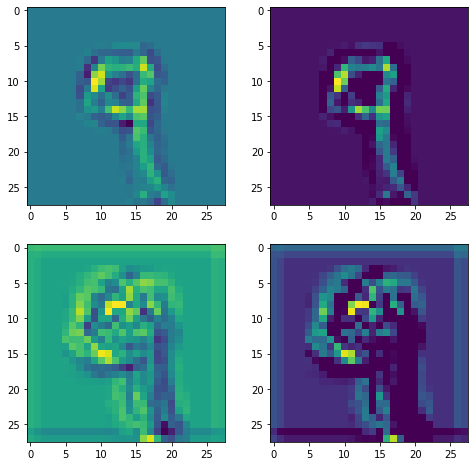

In [ ]:
show_convolutions(model3, 2, 2, x_train)

## Model 4

In [ ]:
class Model4:
  def __init__(self):
    self.w_conv1 = weight_variable([5, 5, 1, 32], name="WeightsC1")  # 32 filters of 5X5X1
    self.b_conv1 = bias_variable([32], name="BiasesC1")  # every neuron is a filter for 5X5 pixel sub matrix
    # that means that every 5X5 weights multiplication is summed and added with one bias
    # Stacking a second convolutional layer
    # Max pooling layer of 2x2, pic becomes 14x14x32
    self.w_conv2 = weight_variable([5, 5, 32, 32], name="WeightsC2")  # 64 filters of 5x5x32
    # takes into account the out put of all 32 filters from the first layer.
    self.b_conv2 = bias_variable([32], name="BiasesC2")
    # Stacking a third convolutional layer
    # Max pooling layer of 2x2, pic becomes 7x7x32
    self.w_conv3 = weight_variable([5, 5, 32, 64], name="WeightsC2")  # 64 filters of 5x5x32
    # takes into account the out put of all 32 filters from the first layer.
    self.b_conv3 = bias_variable([64], name="BiasesC2")
     # Fully connected layer of 1024 units
     # Convolution layer with stride 2, pic becomes 4x4x64
     # Max pooling layer of 2x2, pic becomes 2x2x64
    self.w_fc1 = weight_variable([2*2*64, 1024], name="WeightsFC1")
    self.b_fc1 = bias_variable([1024], name="BiasesFC1")
    # Final layer - softmax
    self.w_fc2 = weight_variable([1024, 10], name="WeightsFC2")
    self.b_fc2 = bias_variable([10], name="BiasesFC2")
    self.variables = [self.w_conv1, self.w_conv2, self.w_fc1, self.w_fc2,self.w_conv3, self.b_conv1, self.b_conv2, self.b_conv3, self.b_fc1, self.b_fc2]
   
  def __call__(self, x, training=False, keep_prob=None):
    x = tf.reshape(x, [-1, 28, 28, 1])  # input layer 28x28x1
    # -1 means: compute that dim so other dims will remain as defined.
    h_covn1 = tf.nn.relu(conv2d(x, self.w_conv1) + self.b_conv1)
    h_pool1 = max_pooling_2x2(h_covn1)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, self.w_conv2) + self.b_conv2)
    h_pool2 = max_pooling_2x2(h_conv2)
    h_conv3 = tf.nn.relu(conv2d(h_pool2, self.w_conv3, 2) + self.b_conv3)
    h_pool3 = max_pooling_2x2(h_conv3)
    # Max pooling layer of 2x2, pic becomes 7x7x64
    h_pool3_flat = tf.reshape(h_pool3, [-1, 2*2*64])  
    # -1 means: compute that dim so other dims will remain as defined.
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, self.w_fc1) + self.b_fc1)
    return tf.matmul(h_fc1, self.w_fc2) + self.b_fc2    

In [ ]:
start = time.time()
model4 = Model4()

# Calculate Recall, Precision, F1_Score, Accuracy of Traning data
train_recall4, train_precision4, train_f1_score4, train_accuracy4, iter_time4 = calculate_train_stats(model4, train_ds)
end = time.time()
time4 = end - start

# Calculate Recall, Precision, F1_Score, Accuracy of Validation data
val_recall4, val_precision4, val_f1_score4, val_accuracy4 = calculate_test_stats(model4, val_ds)

# Calculate Recall, Precision, F1_Score, Accuracy of Test data
test_recall4, test_precision4, test_f1_score4, test_accuracy4 = calculate_test_stats(model4, test_ds)

Step 0, training accuracy 0.14
Step 100, training accuracy 0.9
Step 200, training accuracy 0.98
Step 300, training accuracy 0.98
Step 400, training accuracy 0.96
Step 500, training accuracy 0.94
Step 600, training accuracy 1
Step 700, training accuracy 0.98
Step 800, training accuracy 0.98
Step 900, training accuracy 0.98
Step 1000, training accuracy 1
Step 1100, training accuracy 1
Step 1200, training accuracy 1
Step 1300, training accuracy 1
Step 1400, training accuracy 1
Step 1500, training accuracy 1
Step 1600, training accuracy 0.98
Step 1700, training accuracy 1
Step 1800, training accuracy 1
Step 1900, training accuracy 1
Step 2000, training accuracy 1
Step 2100, training accuracy 1
Step 2200, training accuracy 1
Step 2300, training accuracy 0.96
Step 2400, training accuracy 0.98
Step 2500, training accuracy 0.98
Step 2600, training accuracy 0.98
Step 2700, training accuracy 0.98
Step 2800, training accuracy 1
Step 2900, training accuracy 1
Step 3000, training accuracy 1
Step 31

In [ ]:
print("Time = ", time4)
print("Weights amount = ", calculate_num_of_weights(model4.variables))
print("Training Results:")
print("\tRecall = %g" % train_recall4)
print("\tPrecision = %g" % train_precision4)
print("\tF1 Score = %g" % train_f1_score4)
print("\taccuracy = %g" % train_accuracy4)
print("\nValidation Results:")
print("\tRecall = %g" % val_recall4)
print("\tPrecision = %g" % val_precision4)
print("\tF1 Score = %g" % val_f1_score4)
print("\taccuracy = %g" % val_accuracy4)
print("\nTest Results:")
print("\tRecall = %g" % test_recall4)
print("\tPrecision = %g" % test_precision4)
print("\tF1 Score = %g" % test_f1_score4)
print("\taccuracy = %g" % test_accuracy4)

Time =  269.86057209968567
Weights amount =  351146
Training Results:
	Recall = 0.979176
	Precision = 0.979628
	F1 Score = 0.978617
	accuracy = 0.989466

Validation Results:
	Recall = 0.985385
	Precision = 0.985647
	F1 Score = 0.984278
	accuracy = 0.989917

Test Results:
	Recall = 0.987179
	Precision = 0.987578
	F1 Score = 0.98624
	accuracy = 0.9907


#### **Convolution First and Second Layers**

<Figure size 432x288 with 0 Axes>

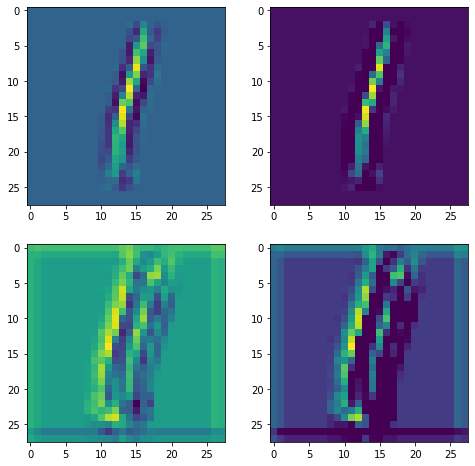

In [ ]:
show_convolutions(model4, 2, 2, x_train)

## Model 5

In [ ]:
class Model5:
  def __init__(self):
    self.w_conv1 = weight_variable([5, 5, 1, 32], name="WeightsC1")  # 32 filters of 5X5X1
    self.b_conv1 = bias_variable([32], name="BiasesC1")  # every neuron is a filter for 5X5 pixel sub matrix
    # that means that every 5X5 weights multiplication is summed and added with one bias
    # Stacking a second convolutional layer
    # Max pooling layer of 2x2, pic becomes 14x14x32
    self.w_conv2 = weight_variable([5, 5, 32, 32], name="WeightsC2")  # 64 filters of 5x5x32
    # takes into account the out put of all 32 filters from the first layer.
    self.b_conv2 = bias_variable([32], name="BiasesC2")
    # Stacking a third convolutional layer
    # Max pooling layer of 2x2, pic becomes 7x7x32
    self.w_conv3 = weight_variable([5, 5, 32, 64], name="WeightsC2")  # 64 filters of 5x5x32
    # takes into account the out put of all 32 filters from the first layer.
    self.b_conv3 = bias_variable([64], name="BiasesC2")
     # Fully connected layer of 1024 units
     # Convolution layer with stride 2, pic becomes 4x4x64
     # Max pooling layer of 2x2, pic becomes 2x2x64
    self.w_fc1 = weight_variable([2*2*64, 1024], name="WeightsFC1")
    self.b_fc1 = bias_variable([1024], name="BiasesFC1")
    # Final layer - softmax
    self.w_fc2 = weight_variable([1024, 10], name="WeightsFC2")
    self.b_fc2 = bias_variable([10], name="BiasesFC2")
    self.variables = [self.w_conv1, self.w_conv2, self.w_fc1, self.w_fc2,self.w_conv3, self.b_conv1, self.b_conv2, self.b_conv3, self.b_fc1, self.b_fc2]
   
  def __call__(self, x, training, keep_proba=None):
    x = tf.reshape(x, [-1, 28, 28, 1])  # input layer 28x28x1
    # -1 means: compute that dim so other dims will remain as defined.
    h_covn1 = tf.nn.relu(conv2d(x, self.w_conv1) + self.b_conv1)
    h_pool1 = max_pooling_2x2(h_covn1)
    h_conv2 = tf.nn.relu(conv2d(h_pool1, self.w_conv2) + self.b_conv2)
    h_pool2 = max_pooling_2x2(h_conv2)
    h_conv3 = tf.nn.relu(conv2d(h_pool2, self.w_conv3, 2) + self.b_conv3)
    h_pool3 = max_pooling_2x2(h_conv3)
    # Max pooling layer of 2x2, pic becomes 7x7x64
    h_pool3_flat = tf.reshape(h_pool3, [-1, 2*2*64])  
    # -1 means: compute that dim so other dims will remain as defined.
    h_fc1 = tf.nn.relu(tf.matmul(h_pool3_flat, self.w_fc1) + self.b_fc1)  
    # Dropout
    if training:
      rate = 1 - keep_proba
      h_fc1 = tf.nn.dropout(h_fc1, rate=rate)
    return tf.matmul(h_fc1, self.w_fc2) + self.b_fc2    

In [ ]:
start = time.time()
model5 = Model5()
keep_prob = 0.5

# Calculate Recall, Precision, F1_Score, Accuracy of Traning data
train_recall5, train_precision5, train_f1_score5, train_accuracy5, iter_time5 = calculate_train_stats(model5, train_ds, True, keep_prob, True)
end = time.time()
time5 = end - start

# Calculate Recall, Precision, F1_Score, Accuracy of Validation data
val_recall5, val_precision5, val_f1_score5, val_accuracy5 = calculate_test_stats(model5, val_ds)

# Calculate Recall, Precision, F1_Score, Accuracy of Test data
test_recall5, test_precision5, test_f1_score5, test_accuracy5 = calculate_test_stats(model5, test_ds)

Step 0, training accuracy 0.24
Step 100, training accuracy 0.96
Step 200, training accuracy 1
Step 300, training accuracy 0.94
Step 400, training accuracy 0.96
Step 500, training accuracy 0.98
Step 600, training accuracy 0.96
Step 700, training accuracy 1
Step 800, training accuracy 1
Step 900, training accuracy 1
Step 1000, training accuracy 1
Step 1100, training accuracy 0.98
Step 1200, training accuracy 0.98
Step 1300, training accuracy 0.96
Step 1400, training accuracy 1
Step 1500, training accuracy 1
Step 1600, training accuracy 1
Step 1700, training accuracy 1
Step 1800, training accuracy 1
Step 1900, training accuracy 1
Step 2000, training accuracy 1
Step 2100, training accuracy 1
Step 2200, training accuracy 1
Step 2300, training accuracy 0.98
Step 2400, training accuracy 1
Step 2500, training accuracy 1
Step 2600, training accuracy 0.98
Step 2700, training accuracy 1
Step 2800, training accuracy 1
Step 2900, training accuracy 1
Step 3000, training accuracy 0.98
Step 3100, trai

In [ ]:
print("Time = ", time5)
print("Weights amount = ", calculate_num_of_weights(model5.variables))
print("Training Results:")
print("\tRecall = %g" % train_recall5)
print("\tPrecision = %g" % train_precision5)
print("\tF1 Score = %g" % train_f1_score5)
print("\taccuracy = %g" % train_accuracy5)
print("\tNumber of iterations to get 0.99 accuracy: %g iterations" % iter_time5[0])
print("\tTime to get 0.99 accuracy: %g seconds" % iter_time5[1])
print("\nValidation Results:")
print("\tRecall = %g" % val_recall5)
print("\tPrecision = %g" % val_precision5)
print("\tF1 Score = %g" % val_f1_score5)
print("\taccuracy = %g" % val_accuracy5)
print("\nTest Results:")
print("\tRecall = %g" % test_recall5)
print("\tPrecision = %g" % test_precision5)
print("\tF1 Score = %g" % test_f1_score5)
print("\taccuracy = %g" % test_accuracy5)

Time =  272.36460876464844
Weights amount =  351146
Training Results:
	Recall = 0.982784
	Precision = 0.982213
	F1 Score = 0.981986
	accuracy = 0.990687
	Number of iterations to get 0.99 accuracy: 101 iterations
	Time to get 0.99 accuracy: 2.29332 seconds

Validation Results:
	Recall = 0.984257
	Precision = 0.984189
	F1 Score = 0.9828
	accuracy = 0.989083

Test Results:
	Recall = 0.985843
	Precision = 0.985915
	F1 Score = 0.984412
	accuracy = 0.9897


#### **Convolution First and Second Layers**

<Figure size 432x288 with 0 Axes>

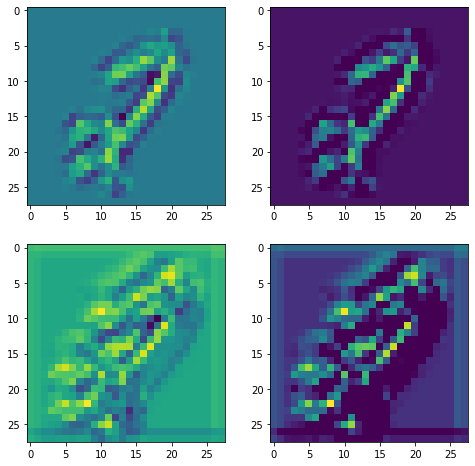

In [ ]:
show_convolutions(model5, 2, 2, x_train)

## Model 6

In [ ]:
large_train_ds = tf.data.Dataset.from_tensor_slices((x_train, t_train)).shuffle(10000).batch(100)
large_test_ds = tf.data.Dataset.from_tensor_slices((x_test_images, t_test)).batch(100)

In [ ]:
start = time.time()
model6 = Model5()
keep_prob = 0.5

# Calculate Recall, Precision, F1_Score, Accuracy of Traning data
train_recall6, train_precision6, train_f1_score6, train_accuracy6, iter_time6 = calculate_train_stats(model6, large_train_ds, True, keep_prob, True)
end = time.time()
time6 = end - start

# Calculate Recall, Precision, F1_Score, Accuracy of Validation data
val_recall6, val_precision6, val_f1_score6, val_accuracy6 = calculate_test_stats(model6, val_ds)

# Calculate Recall, Precision, F1_Score, Accuracy of Test data
test_recall6, test_precision6, test_f1_score6, test_accuracy6 = calculate_test_stats(model6, large_test_ds)

Step 0, training accuracy 0.19
Step 100, training accuracy 0.97
Step 200, training accuracy 0.98
Step 300, training accuracy 0.99
Step 400, training accuracy 0.97
Step 500, training accuracy 0.99
Step 600, training accuracy 0.94
Step 700, training accuracy 1
Step 800, training accuracy 1
Step 900, training accuracy 1
Step 1000, training accuracy 1
Step 1100, training accuracy 1
Step 1200, training accuracy 1
Step 1300, training accuracy 0.99
Step 1400, training accuracy 1
Step 1500, training accuracy 0.97
Step 1600, training accuracy 1
Step 1700, training accuracy 1
Step 1800, training accuracy 1
Step 1900, training accuracy 1
Step 2000, training accuracy 0.99
Step 2100, training accuracy 0.99
Step 2200, training accuracy 0.99
Step 2300, training accuracy 0.99
Step 2400, training accuracy 1
Step 2500, training accuracy 0.98
Step 2600, training accuracy 1
Step 2700, training accuracy 1
Step 2800, training accuracy 1
Step 2900, training accuracy 1
Step 3000, training accuracy 1
Step 3100

In [ ]:
print("Time = ", time6)
print("Weights amount = ", calculate_num_of_weights(model6.variables))
print("Training Results:")
print("\tRecall = %g" % train_recall6)
print("\tPrecision = %g" % train_precision6)
print("\tF1 Score = %g" % train_f1_score6)
print("\taccuracy = %g" % train_accuracy6)
print("\tNumber of iterations to get 0.99 accuracy: %g iterations" % iter_time6[0])
print("\tTime to get 0.99 accuracy: %g seconds" % iter_time6[1])
print("\nValidation Results:")
print("\tRecall = %g" % val_recall6)
print("\tPrecision = %g" % val_precision6)
print("\tF1 Score = %g" % val_f1_score6)
print("\taccuracy = %g" % val_accuracy6)
print("\nTest Results:")
print("\tRecall = %g" % test_recall6)
print("\tPrecision = %g" % test_precision6)
print("\tF1 Score = %g" % test_f1_score6)
print("\taccuracy = %g" % test_accuracy6)

Time =  283.9542384147644
Weights amount =  351146
Training Results:
	Recall = 0.991393
	Precision = 0.991651
	F1 Score = 0.99087
	accuracy = 0.991527
	Number of iterations to get 0.99 accuracy: 181 iterations
	Time to get 0.99 accuracy: 4.18787 seconds

Validation Results:
	Recall = 0.985971
	Precision = 0.985672
	F1 Score = 0.984637
	accuracy = 0.991083

Test Results:
	Recall = 0.992363
	Precision = 0.992225
	F1 Score = 0.991908
	accuracy = 0.9923


#### **Convolution First and Second Layers**

<Figure size 432x288 with 0 Axes>

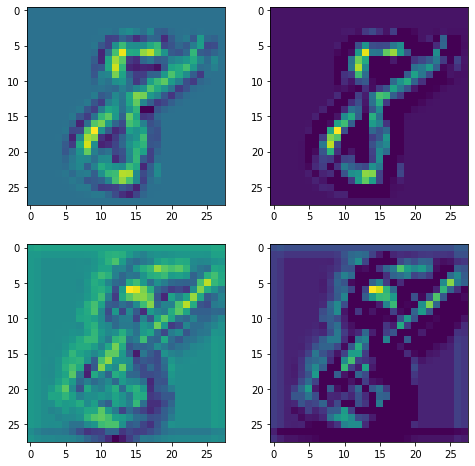

In [ ]:
show_convolutions(model6, 2, 2, x_train)

## Best F-Score Model Visualization
We can see that model 6 has the best F1 score that is 0.9919

<Figure size 432x288 with 0 Axes>

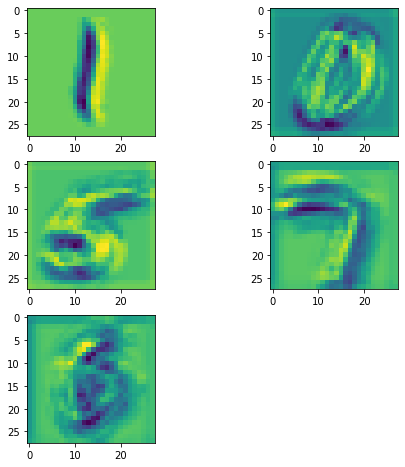

In [ ]:
show_visualizations(model6, 3, 2, 5, x_test_images)

# -----------------------------------------------------------------------------

Target: tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Predicted distributions: tf.Tensor(
[[-383.08563 -385.15106 -375.54926 -322.71863 -409.709   -350.36322
  -398.1887  -384.61093 -353.637   -391.12805]], shape=(1, 10), dtype=float32)
Predicted result: tf.Tensor([3], shape=(1,), dtype=int64)


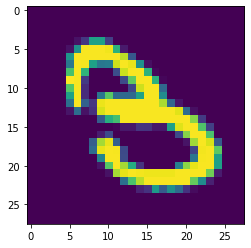

In [ ]:
# print(x_train_images)
i = 18
imgplot = plt.imshow(x_test_images[i])
print("Target:", t_test[i])
print("Predicted distributions:", model5(x_test_images[i], False))
print("Predicted result:", tf.math.argmax(model6(x_test_images[i], False), 1))